In [25]:
# Import the pipeline helper from the transformers package, which we will use to load our model
from transformers import pipeline

import pandas as pd
import re
import nltk
import sklearn
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


In [6]:
pip install tensorflow

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Download and instantiate the facebook/bart-large-mlni model and pipeline. The first time this cell runs, it downloads a large file containing the model weights (1.5GB of parameters all in all!). 
# Let it finish and from then on it will be cached on disk.

# Stay aware that this model instantiation uses a lot of memory/RAM, as it has to load the full 1.5GB of model parameters. If you load the model as below in several notebooks at the same time, you might overload your box. 
# To avoid this, when you're done with a notebook, close it's "kernel" on the left side of the Jupyterlabs interface (The second icon. circle with a square inside, selects the active kernels). This unloads the model from memory.

c = pipeline('zero-shot-classification', model='facebook/bart-large-mnli')

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [3]:
data = pd.read_csv('training.csv')

In [4]:
data.head()

,SocialMediaFeed,NVDA,ING,SAN,PFE,CSCO
0,@PharmaNews: Pfizer faces backlash over possib...,0.000000,0.0,0.0,-0.029512,0.0
1,@BusinessReport: A recent study found that mos...,0.000000,0.0,0.0,0.000000,0.0
2,@HardwareHubs: NVIDIA's contributions to a maj...,0.026125,0.0,0.0,0.000000,0.0
3,@HealthWatch: Johnson & Johnson faces lawsuits...,0.000000,0.0,0.0,0.000000,0.0
4,@IndustryInsider: Magnificent Honary faces pro...,0.000000,0.0,0.0,0.000000,0.0


<Axes: title={'center': 'News Messages'}>

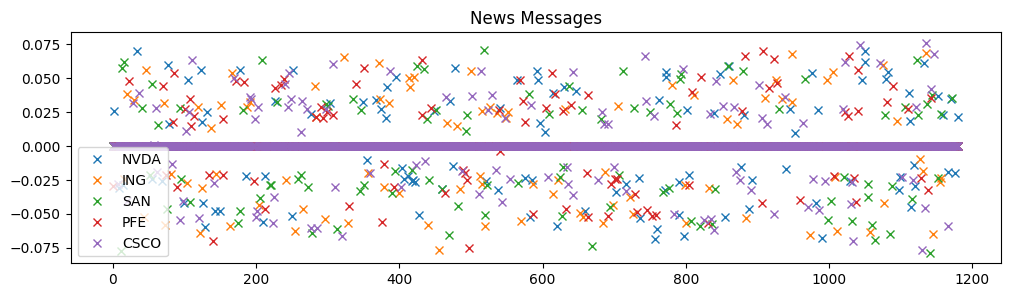

In [ ]:
data.plot(marker='x', linestyle='', figsize=(12, 3), title='News Messages')

In [26]:
# not required as bard llm is already in use
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove URLs, hashtags, mentions, special characters, and numbers
    text = re.sub(r'http\S+|www\S+|https\S+|@\S+|#\S+|[^\w\s]|[\d]', '', text)
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Apply preprocessing to the SocialMediaFeed column
data['preprocessed'] = data['SocialMediaFeed'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /home/ian/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/ian/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/ian/nltk_data...


In [31]:
data['preprocessed']

0       pfizer face backlash possible closure regional...
1       recent study found ceo read business book expl...
2       nvidias contribution major industry collaborat...
3       johnson johnson face lawsuit product safety co...
4                magnificent honary face production delay
                              ...                        
1177    walmarts new sustainable packaging initiative ...
1178    despite market fluctuation today corporate new...
1179    today world ecology forum announces plan prese...
1180    unconfirmed report hint potential netflix expa...
1181    unconfirmed report nvidias plan enter ai chip ...
Name: preprocessed, Length: 1182, dtype: object

In [32]:
SocialMediaFeed = data['SocialMediaFeed']

In [18]:
import pandas as pd

# Initialize dictionaries to hold DataFrames for each company
company_dfs = {
    'Pfizer': pd.DataFrame(columns=['sequence', 'Profitable', 'Not Profitable']),
    'NVIDIA': pd.DataFrame(columns=['sequence', 'Profitable', 'Not Profitable']),
    'Cisco': pd.DataFrame(columns=['sequence', 'Profitable', 'Not Profitable']),
    'Santander': pd.DataFrame(columns=['sequence', 'Profitable', 'Not Profitable']),
    'ING': pd.DataFrame(columns=['sequence', 'Profitable', 'Not Profitable'])
}

# Loop through each item in the social media feed
for item in SocialMediaFeed:
    # Get the sentiment analysis result
    result = c(item, ['Profitable', 'Not Profitable'])
    
    temp_scores = {'Profitable': None, 'Not Profitable': None}
    for label, score in zip(result['labels'], result['scores']):
        temp_scores[label] = score

    # Check for company mentions and append to the corresponding DataFrame
    for company in company_dfs.keys():
        if company in item:  # Assuming 'item' contains the text where you're searching for company names
            new_row = pd.DataFrame ({
                'sequence': [result['sequence']],
                'Profitable': [temp_scores['Profitable']], 
                'Not Profitable': [temp_scores['Not Profitable']]
            })
            company_dfs[company] = pd.concat([company_dfs[company], new_row], ignore_index=True)

            # print(company_dfs[company])


# Write each DataFrame to a CSV file
for company, df in company_dfs.items():
    file_path = f'{company}_sentiment_analysis_results.csv'
    df.to_csv(file_path, index=False)
    print(f'Dataframe for {company} written to {file_path} successfully')


/tmp/ipykernel_10139/2972305369.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  company_dfs[company] = pd.concat([company_dfs[company], new_row], ignore_index=True)


KeyboardInterrupt: 

In [21]:
# Checking out the files:
df

,sequence,Profitable,Not Profitable
0,@InsuranceEye: Could ING's recent regional mar...,0.510440,0.489560
1,@BankingUpdate: Rumors of a major deal between...,0.624452,0.375548
2,@InsuranceInsider: ING secures a sizeable gove...,0.975403,0.024597
3,@FinancialExpress: PR or marketing appointment...,0.821393,0.178607
4,"@FinanceWatchEU: Ingeborg Felder, Head of ING ...",0.727819,0.272181
...,...,...,...
128,@InsuranceIntelligence: ING discontinues minor...,0.231127,0.768873
129,@FinanceNewsEU: ING Group announces a new expa...,0.917616,0.082384
130,@InsuranceTrends: ING's seasonal promotions en...,0.429652,0.570348
131,@BankingGossips: Rumored security breaches at ...,0.695381,0.304619


Step 4: Strategy Implementation
For this step, we'll consider the sentiment scores ('Profitable' and 'Not Profitable') in relation to the stock trend data from training.csv. We'll use a simplified logic where:

If the 'Profitable' score is significantly higher than the 'Not Profitable' score, it indicates a positive sentiment, and we might consider this an opportunity to buy or hold the stock.
Conversely, if the 'Not Profitable' score is higher, it indicates a negative sentiment, suggesting a potential risk, and we might consider selling or neutralizing positions.

In [ ]:
# we'll align the sentiment analysis results with the stock trend data, and implement the strategy modification logic based on the combined insights.
def modify_quoter_strategy(sentiment_data, training_data):
    # Align sentiment scores with stock trend data
    # This step would involve matching the sequences from sentiment analysis with those in training_data
    # and then using the corresponding stock change values for decision making

    decisions = []  # List to store decisions (e.g., 'Buy', 'Hold', 'Sell', 'Neutralize')

    for index, row in sentiment_data.iterrows():
        # Example decision-making logic based on sentiment scores
        if row['Profitable'] > row['Not Profitable'] + 0.2:  # Threshold can be adjusted
            decision = 'Buy/Hold'
        elif row['Not Profitable'] > row['Profitable'] + 0.2:  # Threshold can be adjusted
            decision = 'Sell/Neutralize'
        else:
            decision = 'Undecided'
        
        decisions.append(decision)

    # Add decisions to the Pfizer data DataFrame
    sentiment_data['Decision'] = decisions

    return sentiment_data

# Reading in the sentiment analysis results
pfizer_data = pd.read_csv('Pfizer_sentiment_analysis_results.csv')
nvidia_data = pd.read_csv('NVIDIA_sentiment_analysis_results.csv')
cisco_data = pd.read_csv('Cisco_sentiment_analysis_results.csv')
santander_data = pd.read_csv('Santander_sentiment_analysis_results.csv')
ing_data = pd.read_csv('ING_sentiment_analysis_results.csv')
# Apply the strategy modification function
modified_pfizer_data = modify_quoter_strategy(pfizer_data, data)

# Display the modified DataFrame with decisions
print(modified_pfizer_data.head())
